In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

# Tổng quan về tập dữ liệu

In [2]:
df = pd.read_csv("/kaggle/input/emotions-in-text/Emotion_final.csv")
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


<AxesSubplot:xlabel='Emotion', ylabel='count'>

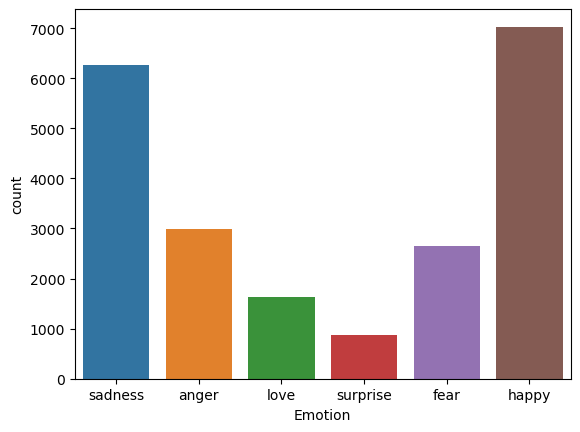

In [4]:
sns.countplot(x="Emotion", data=df)

# Tiền xử lý dữ liệu

* ### Chuyển tất cả về chữ thường

In [5]:
#ex: "I'm feeling grouchy!"
# => "i'm feeling grouchy!"
df["Text"] = df["Text"].str.lower()

* ### Loại bỏ dấu câu

In [6]:
#ex: "i'm feeling grouchy!"
# => "im feeling grouchy"
def remove_punctuation(text):
  return re.sub(r'[^\w\s]', '', text)
  
df["Text"] = df["Text"].apply(lambda text: remove_punctuation(text))

* ### Loại bỏ từ dừng

In [7]:
#ex: "i feel romantic too"
# => "feel romantic"
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
", ".join(stopwords.words('english'))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["Text"] = df["Text"].apply(lambda text: remove_stopwords(text))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* ### Rút gọn từ về từ gốc

In [8]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [9]:
from nltk.stem import WordNetLemmatizer

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join(list([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]))

df['Text'] = df["Text"].apply(lemmatize_text)

* ### Loại bỏ các từ thường xuyên xuất hiện và hiếm khi xuất hiện không mang ý nghĩa phân loại

In [10]:
#ex: "im feel grouchy"
# => "grouchy"
from collections import Counter
cnt = Counter()
for text in df["Text"].values:
    for word in text.split():
        cnt[word] += 1

FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["Text"] = df["Text"].apply(lambda text: remove_freqwords(text))

# removal of rare words
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])
df["Text"] = df["Text"].apply(lambda text: remove_rarewords(text))

* ### Vector hoá dữ liệu

In [11]:
# Using CountVectorizer
# ex: "one cent two cent old cent new cent all money"
# sparse vector: [[102, 1], [1991, 4], [985, 1], ...]
# 102 is value of "one" in vocabulary
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
features_1 = vectorizer.fit_transform(df["Text"])

print(np.shape(features_1))
print(len(vectorizer.vocabulary_))

(21459, 17132)
17132


In [12]:
# Using TfidfVectorizer
# ex: "become overwhelmed defeated"
# sparse vector: [[988, 0.152], [2615, 0.651], [6114, 0.823]]
# 988 is value of "become" in vocabulary
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
features_2 = vectorizer.fit_transform(df["Text"])

print(np.shape(features_2))
print(len(vectorizer.vocabulary_))

(21459, 17132)
17132


* ### Mã hoá nhãn

In [13]:
# {"anger": 1, "fear": 2, "happy": 3, "love": 4, "sadness": 5, "surprise": 6}
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(np.array(df.Emotion).reshape(-1,1))

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


* ### Chia tập dữ liệu

In [14]:
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features_1, y, test_size=0.1, stratify=y)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features_2, y, test_size=0.1, stratify=y)

print(X_train_1.shape)
print(X_train_2.shape)

(19313, 17132)
(19313, 17132)


# Huấn luyện mô hình

In [15]:
import time

### KNN

In [16]:
# K Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier

# using CountVectorizer
classifier_knn_1 = KNeighborsClassifier(n_neighbors=7, weights="distance")
t = time.time()
classifier_knn_1.fit(X_train_1,y_train_1)
time_for_train_knn_1 = time.time()-t
print(f'Time Taken using CountVectorizer: {time_for_train_knn_1} seconds')

# using TfidfVectorizer
classifier_knn_2 = KNeighborsClassifier(n_neighbors=7, weights="distance")
t = time.time()
classifier_knn_2.fit(X_train_2,y_train_2)
time_for_train_knn_2 = time.time()-t
print(f'Time Taken using TfidfVectorizer: {time_for_train_knn_2} seconds')

Time Taken using CountVectorizer: 0.0029091835021972656 seconds
Time Taken using TfidfVectorizer: 0.0029273033142089844 seconds


## Navie Bayes

In [17]:
# Navie Bayes
from sklearn.naive_bayes import  MultinomialNB

classifier_nb = MultinomialNB()
t = time.time()
classifier_nb.fit(X_train_1, y_train_1)
time_for_train_nb = time.time()-t
print(f'Time Taken: {time_for_train_nb} seconds')

Time Taken: 0.01030874252319336 seconds


## SVM

In [18]:
# Soft Margin Suport Vector Machine
from sklearn.svm import SVC

# svm linear
classifier_svm_linear_1 = SVC(C = 1,kernel = 'linear')
t = time.time()
classifier_svm_linear_1.fit(X_train_1, y_train_1)
time_for_train_svm_linear_1 = time.time()-t
print(f'linear SVM Taken: {time_for_train_svm_linear_1} seconds')

classifier_svm_linear_2 = SVC(C = 1,kernel = 'linear')
t = time.time()
classifier_svm_linear_2.fit(X_train_2, y_train_2)
time_for_train_svm_linear_2 = time.time()-t
print(f'linear SVM Taken: {time_for_train_svm_linear_2} seconds')

linear SVM Taken: 18.667097568511963 seconds
linear SVM Taken: 26.541107892990112 seconds


# Đánh giá mô hình

In [19]:
# evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
class_names = ["anger", "fear", "happy", "love", "sadness", "surprise"]

def model_Evaluate(model, X_test, y_test):

  t = time.time()
  y_pred = model.predict(X_test)
  t = time.time() - t
  print(f'Prediction time: {t/len(y_pred)}')
  print(classification_report(y_test, y_pred))

  for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_predictions(
          y_test,
          y_pred,
          display_labels=class_names,
          cmap=plt.cm.Blues,
          normalize=normalize,
      )
      disp.ax_.set_title(title)
      plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
      plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)

## KNN

Prediction time: 0.0004196190322989742
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       299
           1       0.80      0.63      0.71       265
           2       0.74      0.83      0.78       703
           3       0.78      0.49      0.60       164
           4       0.74      0.78      0.76       627
           5       0.66      0.38      0.48        88

    accuracy                           0.73      2146
   macro avg       0.73      0.64      0.67      2146
weighted avg       0.73      0.73      0.73      2146



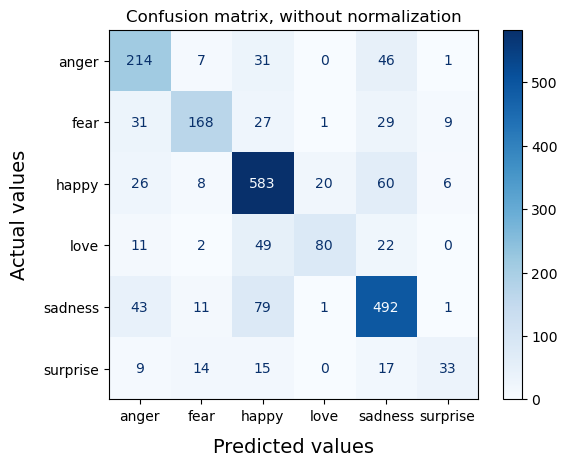

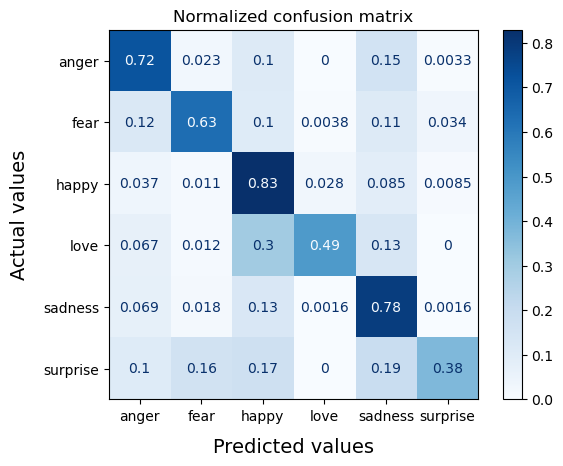

In [20]:
# KNN model using Count Vectorizer
model_Evaluate(classifier_knn_1, X_test_1, y_test_1)

Prediction time: 0.0003116851861745758
              precision    recall  f1-score   support

           0       0.61      0.83      0.71       299
           1       0.83      0.68      0.75       265
           2       0.84      0.83      0.84       703
           3       0.80      0.62      0.70       164
           4       0.84      0.87      0.85       627
           5       0.68      0.45      0.54        88

    accuracy                           0.79      2146
   macro avg       0.77      0.71      0.73      2146
weighted avg       0.80      0.79      0.79      2146



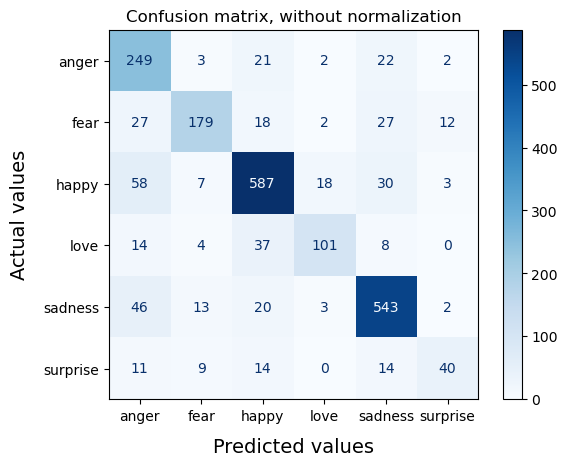

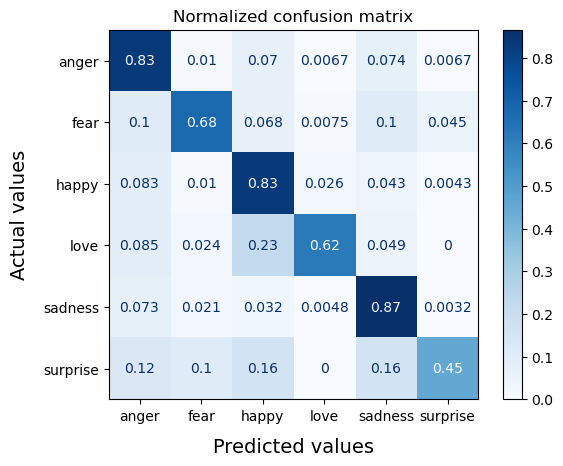

In [21]:
# KNN model using Tfidf Vectorizer
model_Evaluate(classifier_knn_2, X_test_2, y_test_2)

## Navie Bayes

Prediction time: 8.765715699493608e-07
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       299
           1       0.85      0.71      0.77       265
           2       0.79      0.93      0.86       703
           3       0.83      0.44      0.57       164
           4       0.78      0.93      0.85       627
           5       0.78      0.24      0.37        88

    accuracy                           0.81      2146
   macro avg       0.82      0.66      0.70      2146
weighted avg       0.81      0.81      0.79      2146



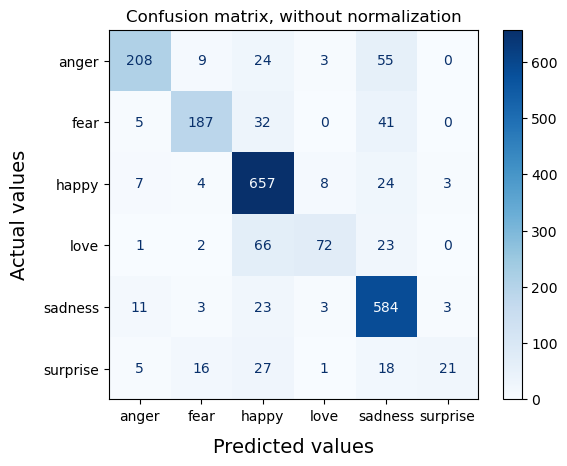

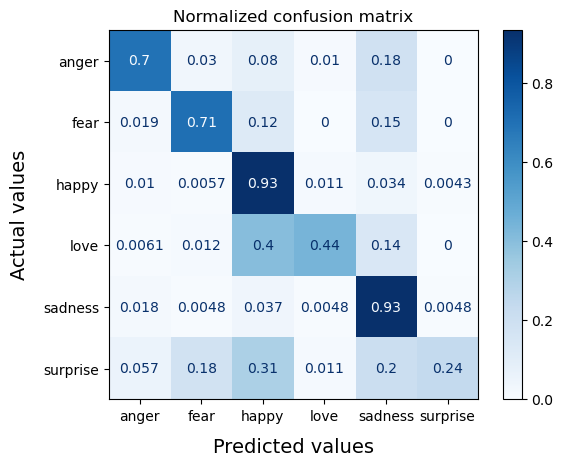

In [22]:
model_Evaluate(classifier_nb, X_test_1, y_test_1)

## SVM

Prediction time: 0.0006396519393423174
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       299
           1       0.84      0.88      0.86       265
           2       0.91      0.91      0.91       703
           3       0.81      0.80      0.81       164
           4       0.92      0.92      0.92       627
           5       0.71      0.61      0.66        88

    accuracy                           0.88      2146
   macro avg       0.84      0.83      0.84      2146
weighted avg       0.88      0.88      0.88      2146



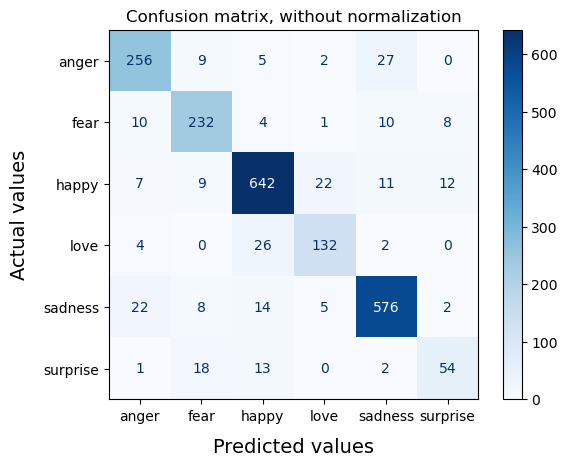

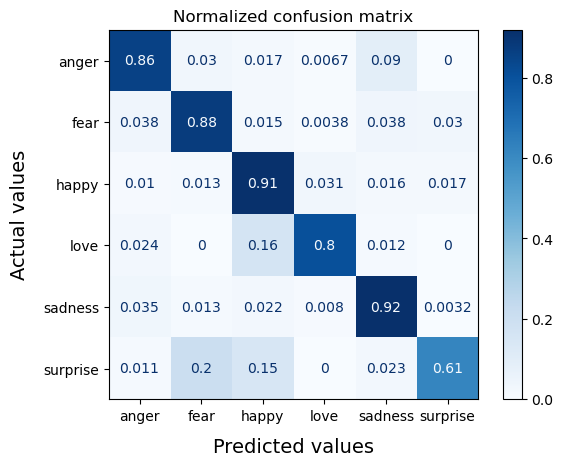

In [23]:
# Count Vectorizer
model_Evaluate(classifier_svm_linear_1, X_test_1, y_test_1)

Prediction time: 0.0007450149532577643
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       299
           1       0.83      0.83      0.83       265
           2       0.89      0.94      0.91       703
           3       0.81      0.68      0.74       164
           4       0.91      0.93      0.92       627
           5       0.83      0.72      0.77        88

    accuracy                           0.88      2146
   macro avg       0.86      0.83      0.84      2146
weighted avg       0.88      0.88      0.88      2146



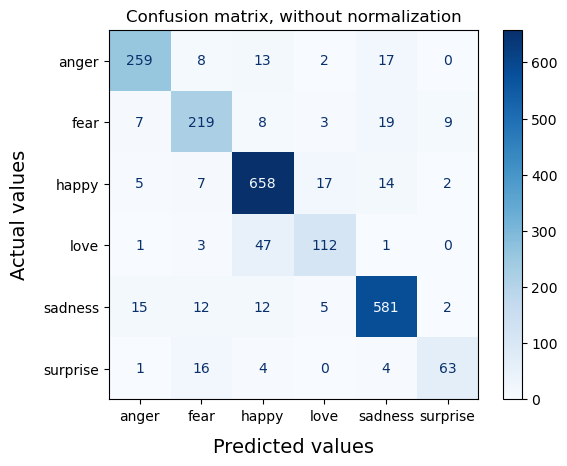

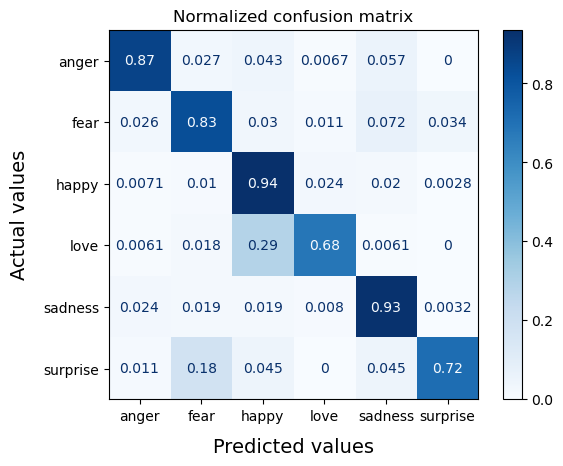

In [24]:
# Tfidf Vectorizer
model_Evaluate(classifier_svm_linear_2, X_test_2, y_test_2)